# Load Dependencies

In [1]:
import urllib.request
import xml.etree.ElementTree as ET
import pandas as pd
import numpy as np
import yfinance as yf
import seaborn as sns

from library import AutoEDA
from library import Explore

from library import create_windowed_df
from library import make_fourier

# Load Data

In [2]:
# Convert the XML of the last 90 days of exchange rates from the ECB website to a pandas DataFrame

last_90 = "https://www.ecb.europa.eu/stats/eurofxref/eurofxref-hist-90d.xml?9531d63dc137832dc128c3fcc9bc4f12"

with urllib.request.urlopen(last_90) as response:
   xml_data = response.read()

root = ET.fromstring(xml_data)

df = pd.DataFrame(columns=['USD', 'JPY', 'BGN', 'CZK', 'DKK', 'GBP', 'CHF'],
                  dtype=np.dtype('float64'))
df.index = df.index.astype(np.dtype('datetime64[ns]'))

cube = root.find('{http://www.ecb.int/vocabulary/2002-08-01/eurofxref}Cube')

currencies_lst = ['USD', 'JPY', 'BGN', 'CZK', 'DKK', 'GBP', 'CHF']
dates = []
currencies_dict = {}

for child in cube:
    dates.append(child.attrib['time'])
    for rate_tag in child:
        currency = list(rate_tag.attrib.values())[0]
        rate = list(rate_tag.attrib.values())[1]
        if currency in currencies_lst:
            if currency in currencies_dict:
                currencies_dict[currency].append(rate)
            else:
                currencies_dict[currency] = [rate]

df = pd.DataFrame.from_dict(currencies_dict, dtype=np.dtype('float64'))
df['date'] = dates
df = df.set_index('date').rename_axis(None)
df.index = df.index.astype(np.dtype('datetime64[ns]'))

USD = df[['USD']]

df.head()

,USD,JPY,BGN,CZK,DKK,GBP,CHF
2024-04-04,1.0852,164.69,1.9558,25.322,7.4589,0.85788,0.9846
2024-04-03,1.0783,163.66,1.9558,25.352,7.4589,0.85713,0.9792
2024-04-02,1.0749,163.01,1.9558,25.361,7.4582,0.85510,0.9765
2024-03-28,1.0811,163.45,1.9558,25.305,7.4580,0.85510,0.9766
2024-03-27,1.0816,163.52,1.9558,25.319,7.4582,0.85768,0.9811


# Auto Visualization

,index,USD
0,count,62.000000
1,mean,1.084969
2,std,0.006238
3,min,1.071300
4,25%,1.080950
5,50%,1.085050
6,75%,1.089200
7,max,1.098700


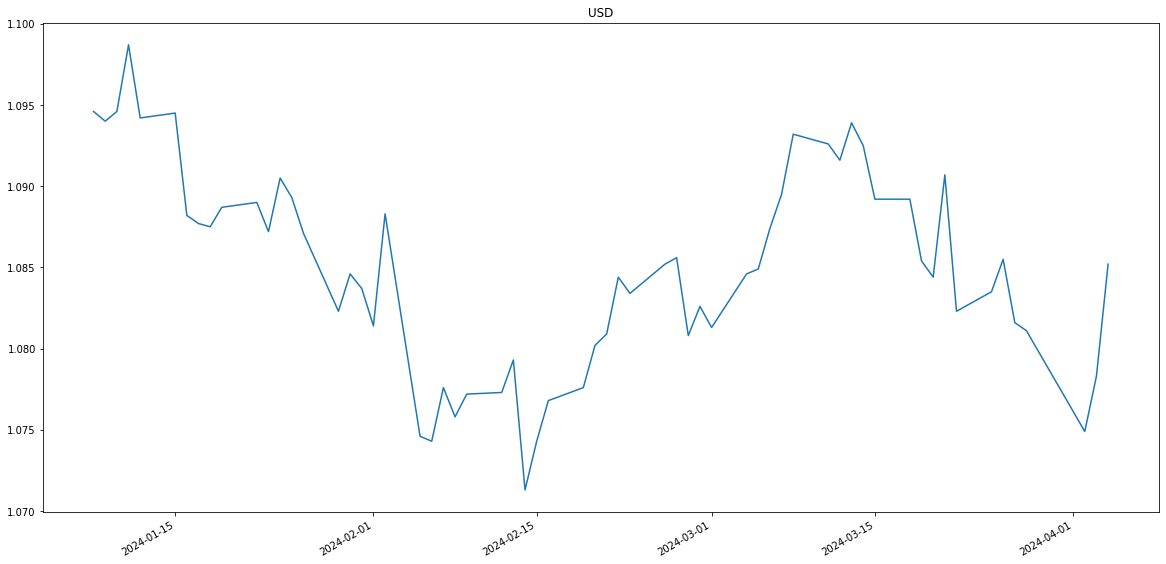

c:\Users\Mayukh Sen\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\categorical.py:632: FutureWarning: SeriesGroupBy.grouper is deprecated and will be removed in a future version of pandas.
  positions = grouped.grouper.result_index.to_numpy(dtype=float)
c:\Users\Mayukh Sen\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\categorical.py:632: FutureWarning: SeriesGroupBy.grouper is deprecated and will be removed in a future version of pandas.
  positions = grouped.grouper.result_index.to_numpy(dtype=float)
c:\Users\Mayukh Sen\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\categorical.py:632: FutureWarning: SeriesGroupBy.grouper is deprecated and will be removed in a future version of pandas.
  positions = grouped.grouper.result_index.to_numpy(dtype=float)
c:\Users\Mayukh Sen\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\categorical.py:632: FutureWarning: SeriesGroupBy.grouper is deprecated and will be removed in a

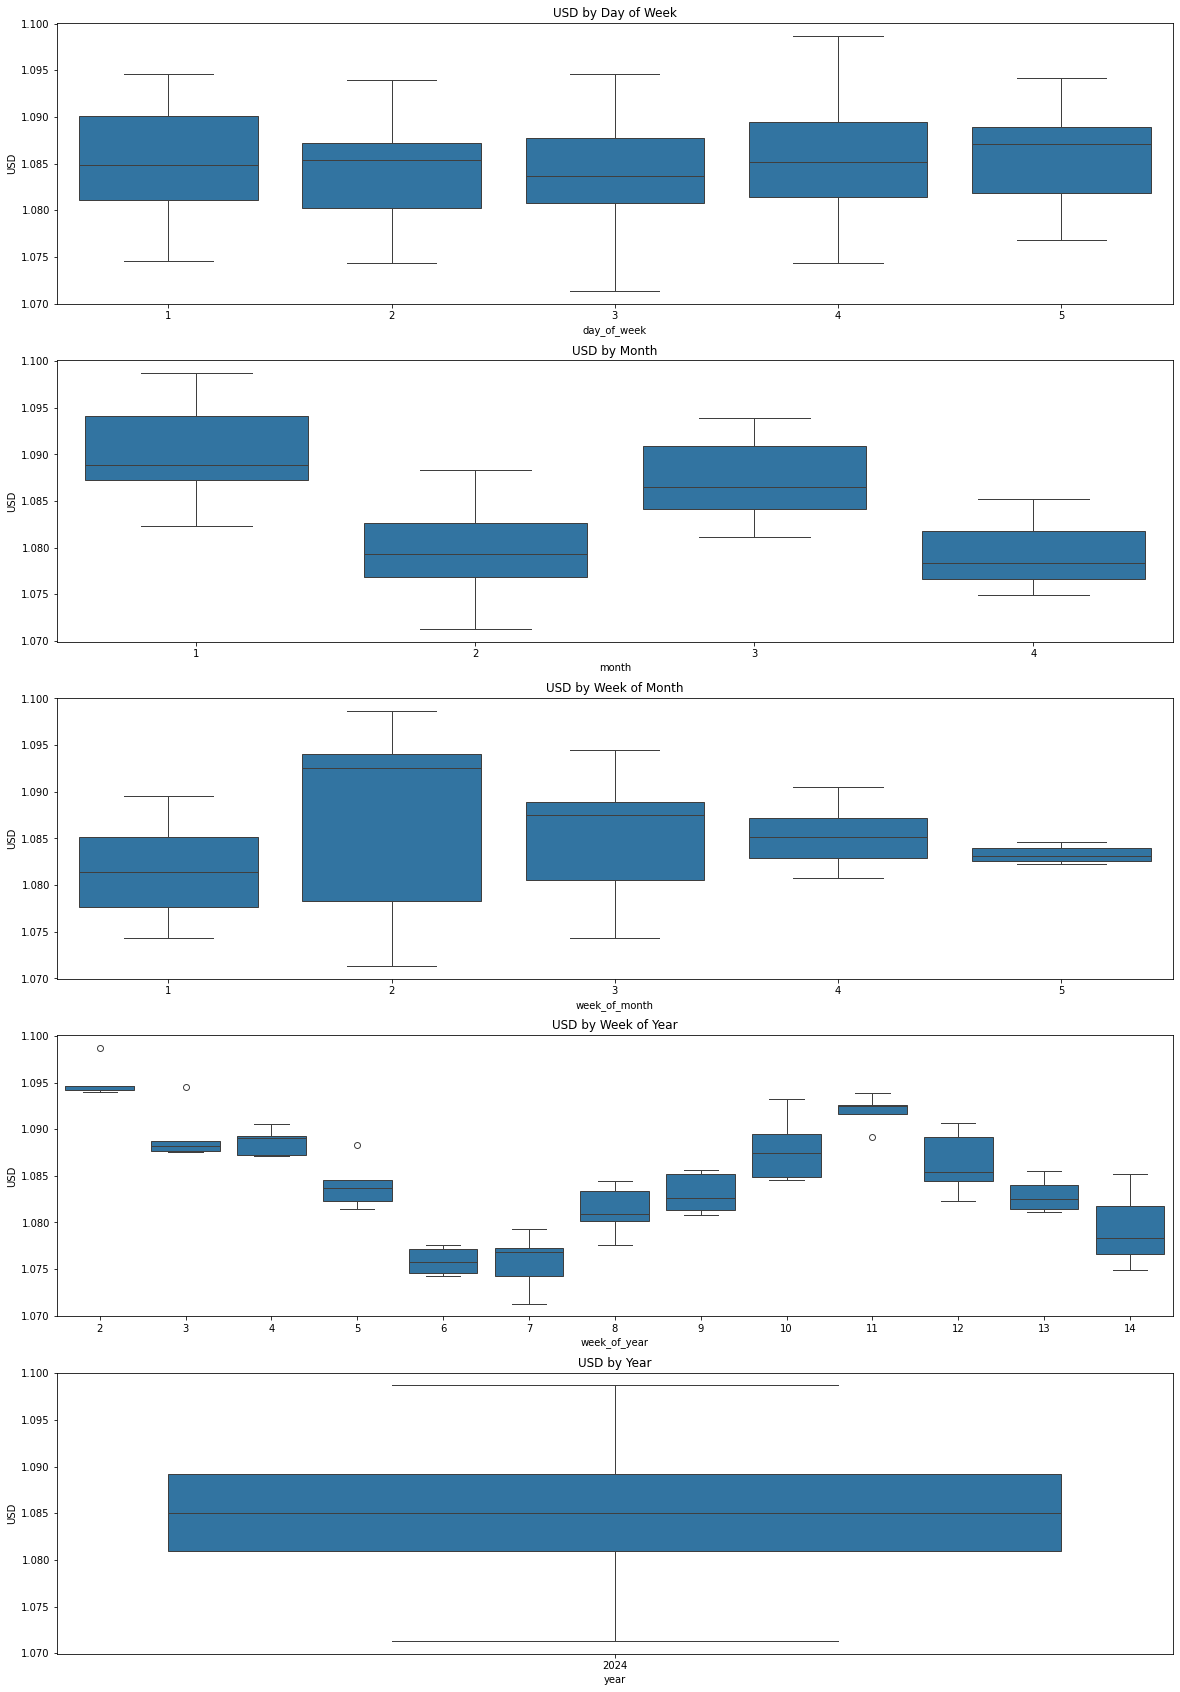

c:\Users\Mayukh Sen\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
c:\Users\Mayukh Sen\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
c:\Users\Mayukh Sen\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset =

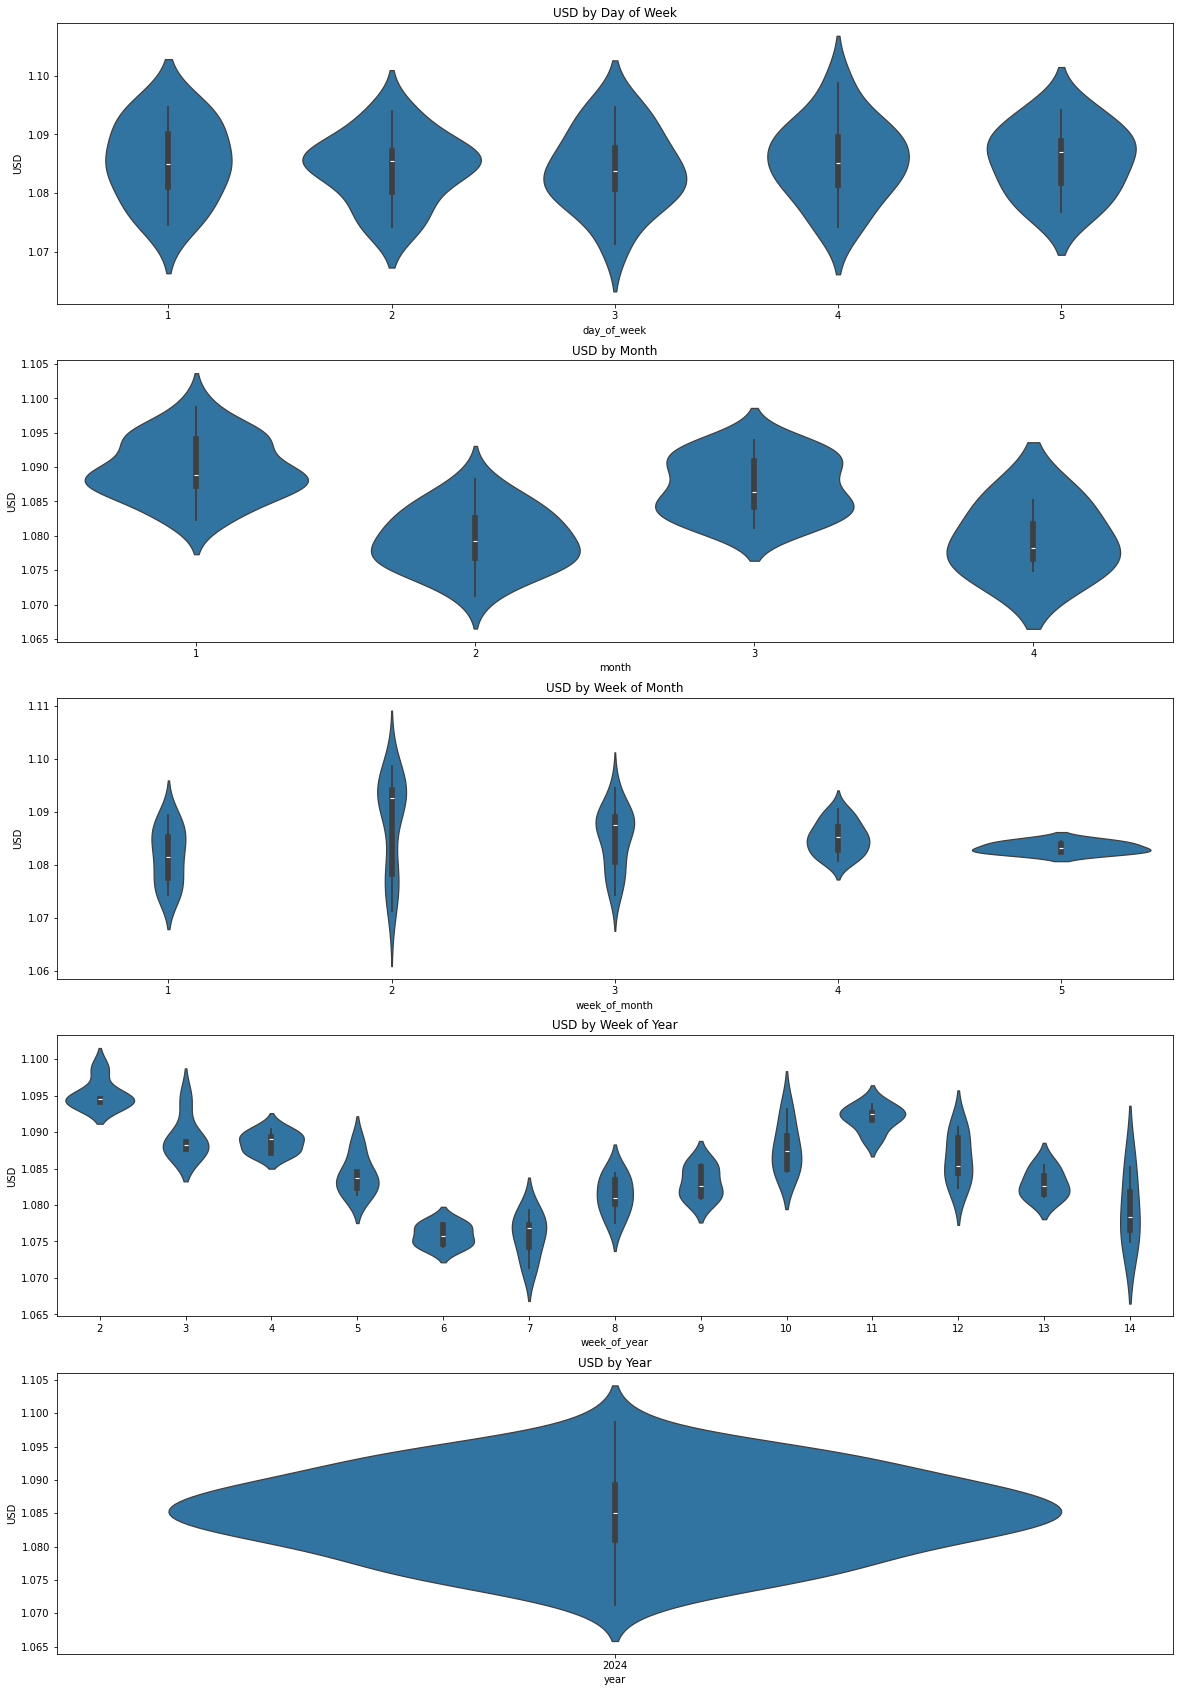

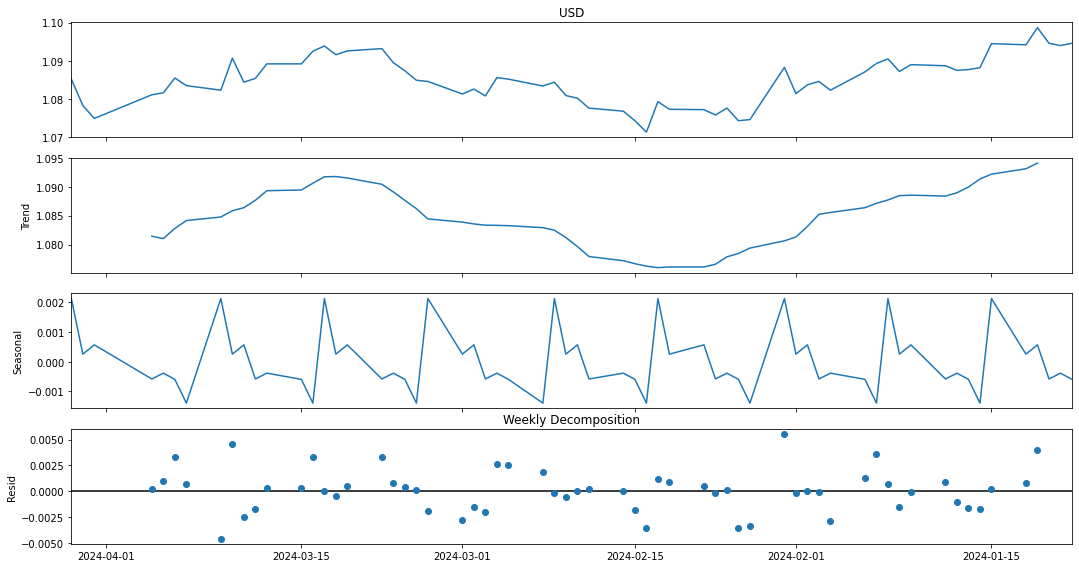

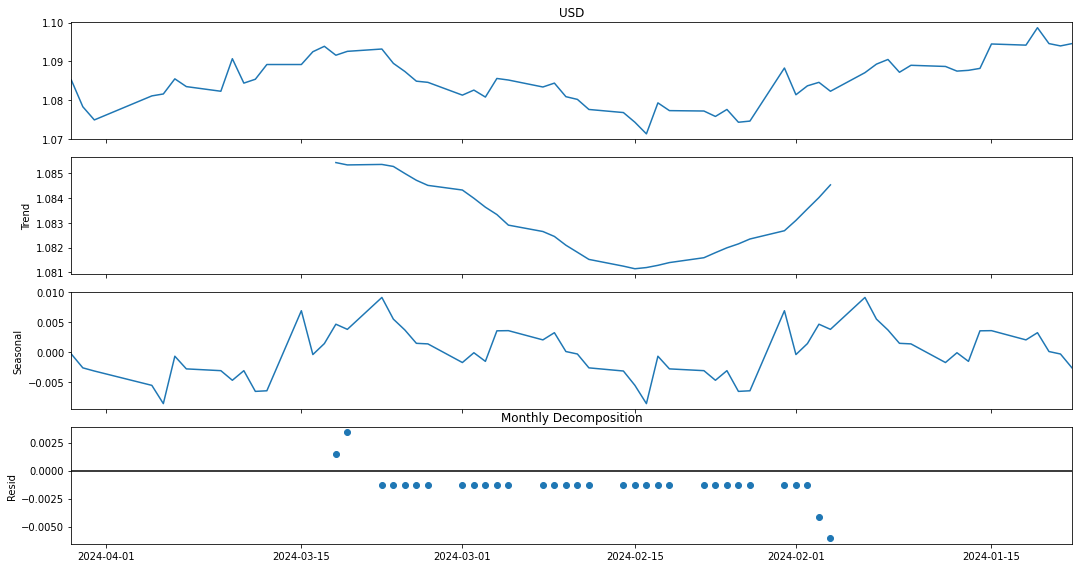

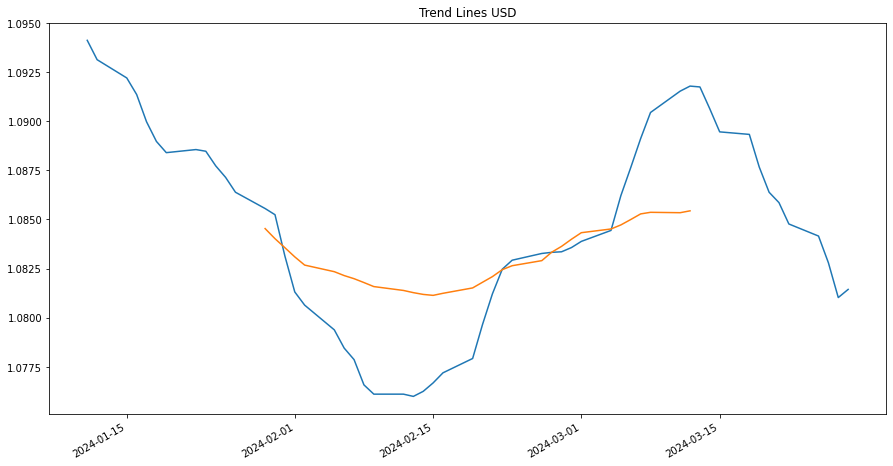

d:\Rutgers MSDS\Data Wrangling\auto_eda copy2\library.py:186: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  g = df.groupby(pd.Grouper(key=dt_col, freq=freq))


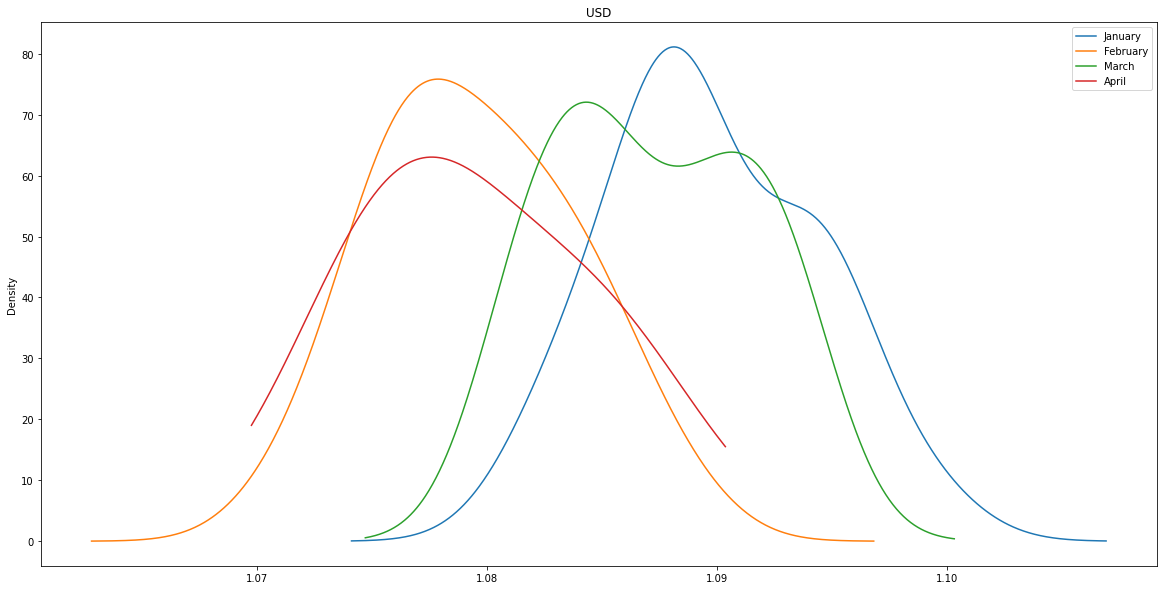

d:\Rutgers MSDS\Data Wrangling\auto_eda copy2\library.py:186: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  g = df.groupby(pd.Grouper(key=dt_col, freq=freq))


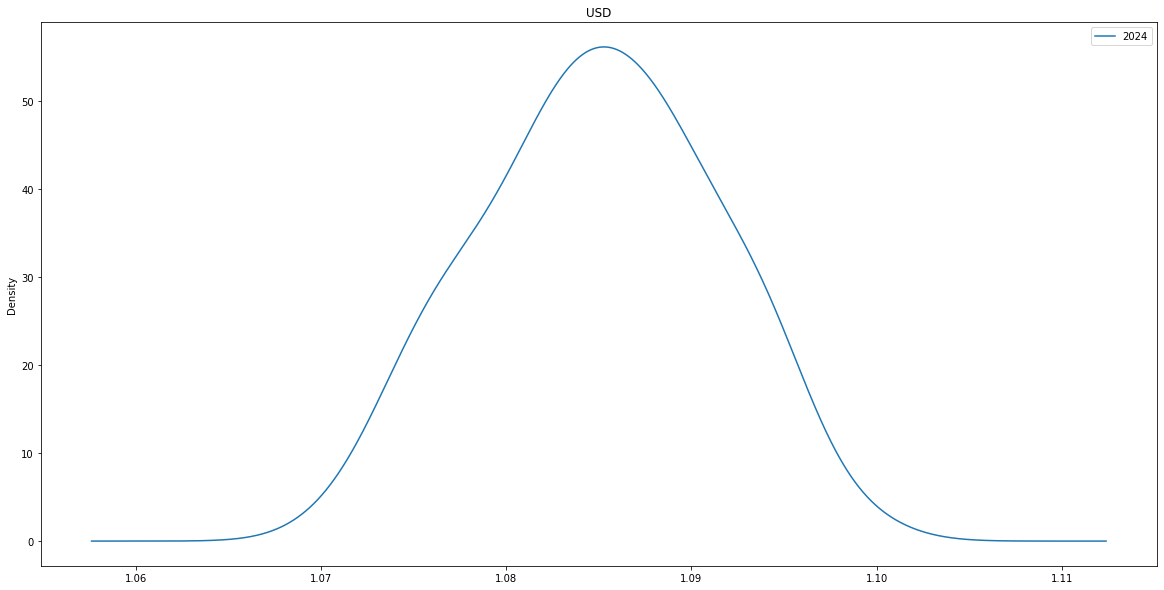

In [3]:
Explore(USD, 'USD')

# Data Analysis/ ML

obj = AutoEDA(USD, 'USD')
dates_df = obj.append_datetime_cols()

fourier_df = make_fourier(dates_df, ['month', 'day', 'week_of_year', 'week_of_month', 'day_of_week'])
display(fourier_df.head())

# TODO: harmonic regression

# see https://www.youtube.com/watch?v=S_Z8RnTE5dI ~52:00 minute mark

eleven_window = create_windowed_df(USD, 10, 'USD')
display(eleven_window.head(11))

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

X = eleven_window.drop('USD', axis=1)  
y = eleven_window['USD']  

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

rf_regressor = RandomForestRegressor(n_estimators=100, random_state=42)

rf_regressor.fit(X_train, y_train)

predictions = rf_regressor.predict(X_test)

mse = mean_squared_error(y_test, predictions)
print('Mean Squared Error:', mse)

# Data Augmentation

spy = yf.Ticker("SPY")
spy_hist = spy.history(period="6mo")
spy_hist = spy_hist[['Close']]
spy_hist.index = spy_hist.index.date

df_augmented = pd.merge(df, spy_hist, left_index=True, right_index=True, how='left')
df_augmented = df_augmented.dropna()

corr = df_augmented.corr()
sns.heatmap(corr)

# TODO: pca and scree plots